# Robustness and Plasticity in Regulatory Networks

* [Introduction](./RPRN-Introduction.ipynb)
* [BoolNet](#BoolNet)
    * [Installation](#Installation)
    * [Network construction](#Network-construction)
    * [Attractors](#Attractors)
    * [Labels](#Labels)
* [Functions](./RPRN-Functions.ipynb)
* [Updating](./RPRN-Updating.ipynb)
* [States and trajectories](./RPRN-States-Trajectories.ipynb)
* [Appendix](./RPRN-Appendix.ipynb)

# BoolNet

Once a regulatory network has been constructed there exist [multiple tools](http://www.colomoto.org/software/) to analyse it. In this tutorial we will focus in the R package [Boolnet](https://cran.r-project.org/web/packages/BoolNet/index.html) and [BoolNetPerturb](https://github.com/mar-esther23/boolnet-perturb).

It is possible to combine the different software tools to make a better analysis, the standar format for saving a logical regulatory network is [SBML-qual](http://www.colomoto.org/formats/sbml-qual.html) (see the [Appendix](./RPRN-Appendix.ipynb) for more information).

Sometimes it is useful to [simplify the network](http://ginsim.org/ginsim-doc/current/algo-reduction.html). 

## Installation

In this tutorial we will use the packages [BoolNet](https://cran.r-project.org/web/packages/BoolNet/index.html) and [BoolNetPerturb](https://github.com/mar-esther23/boolnet-perturb). The package `BoolNet` is available at `CRAN`. The package `BoolNetPerturb` (and this tutorial) are available at `github`.

In [18]:
#Uncomment next line if you haven't installed BoolNet
#install.packages("BoolNet", repos='http://cran.us.r-project.org')
library(BoolNet)

## Uncomment next lines if you haven't installed BoolNetPerturb
#library(devtools)
#install_github("mar-esther23/boolnet-perturb", force = TRUE)
library(BoolNetPerturb)

## Network construction

The interactions of a biological system can be expressed as a set of logical functions using multiple formalisms ([Boolean functions](https://en.wikipedia.org/wiki/Boolean_function), [truth tables](https://en.wikipedia.org/wiki/Truth_table), [Binary Decision Diagrams](https://en.wikipedia.org/wiki/Binary_decision_diagram)). BoolNet accepts a set of boolean functions.

For examplet the Th17/iTreg network can be expressed as a set of boolean functions obtained from the known interactions among the cytokines and transcription factors.

>targets, functions

>IL2, (IL2e | (IL2 &  ! FOXP3)) &  ! (STAT3 | (IL10 & ! FOXP3))

>RORGT, (STAT3 & TGFB) &  ! FOXP3

>STAT3, (IL21e | STAT3 | RORGT) &  ! (IL10 | IL2)

>FOXP3, (IL2 & (TGFB | FOXP3)) &  ! (STAT3 | RORGT)

>TGFB, TGFBe | ((TGFB | FOXP3) &  ! STAT3 )

>IL10, IL10e | (IL10 & (STAT3 | TGFB))

First, we will load BoolNet

In [5]:
#Uncomment next line if you haven't installed BoolNet
#install.packages("BoolNet", repos='http://cran.us.r-project.org')
library(BoolNet)
library(BoolNetPerturb)

Boolnet creates a network object with the function __loadNetwork()__. This function accepts the filename of the file with the rules. In this case we will create the file from the notebook.

In [5]:
fileConn<-file("minTh17iTreg.txt")
writeLines(c(
    "targets, functions",
    "IL2, (IL2e | (IL2 &  ! FOXP3)) &  ! (STAT3 | (IL10 & ! FOXP3))",
    "RORGT, (STAT3 & TGFB) &  ! FOXP3",
    "STAT3, (IL21e | STAT3 | RORGT) &  ! (IL10 | IL2)",
    "FOXP3, (IL2 & (TGFB | FOXP3)) &  ! (STAT3 | RORGT)",
    "TGFB, TGFBe | ((TGFB | FOXP3) &  ! STAT3 )",
    "IL10, IL10e | (IL10 & (STAT3 | TGFB))", 
    "IL2e, IL2e",
    "IL21e, IL21e",
    "TGFBe, TGFBe",
    "IL10e, IL10e"
    ), fileConn)
close(fileConn)

Now we can create a network object. If you don't specify a node BoolNet will raise a warning and asumme it is an input. The resulting network should have ten nodes.

In [6]:
net <- loadNetwork("minTh17iTreg.txt")
net

Boolean network with 10 genes

Involved genes:
IL2 RORGT STAT3 FOXP3 TGFB IL10 IL2e IL21e TGFBe IL10e

Transition functions:
IL2 = (IL2e | (IL2 &  ! FOXP3)) &  ! (STAT3 | (IL10 & ! FOXP3))
RORGT = (STAT3 & TGFB) &  ! FOXP3
STAT3 = (IL21e | STAT3 | RORGT) &  ! (IL10 | IL2)
FOXP3 = (IL2 & (TGFB | FOXP3)) &  ! (STAT3 | RORGT)
TGFB = TGFBe | ((TGFB | FOXP3) &  ! STAT3 )
IL10 = IL10e | (IL10 & (STAT3 | TGFB))
IL2e = IL2e
IL21e = IL21e
TGFBe = TGFBe
IL10e = IL10e

The result is a network object. This object structure is:
* __network__
    * __\$interactions__ : list of nodes where each node has its functions represented as truth tables. (Use iterator or [[n]] to examine each node)
        * __\$input__ : index of regulators
        * __\$func__ : function as truth table
        * __\$expression__ : Boolean function as string
    * __\$genes__ : ordered node names
    * __\$fixed__ : which nodes have fixed values (see [Functions](./RPRN-Functions.ipynb))

In [8]:
net$interactions[[1]]
net$genes
net$fixed

$input
[1] 1 3 4 6 7

$func
 [1] 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0

$expression
[1] "(IL2e | (IL2 &  ! FOXP3)) &  ! (STAT3 | (IL10 & ! FOXP3))"


[1] "IL2"   "RORGT" "STAT3" "FOXP3" "TGFB"  "IL10"  "IL2e"  "IL21e" "TGFBe"
[10] "IL10e"

IL2 RORGT STAT3 FOXP3  TGFB  IL10  IL2e IL21e TGFBe IL10e 
   -1    -1    -1    -1    -1    -1    -1    -1    -1    -1

The Th17/iTreg regulatory network can also be found in the `BoolNetPerturb` data.

In [9]:
data(netTh17iTreg)
netTh17iTreg

Boolean network with 10 genes

Involved genes:
IL2 RORGT STAT3 FOXP3 TGFB IL10 IL2e IL21e TGFBe IL10e

Transition functions:
IL2 = (IL2e | (IL2 &  ! FOXP3)) &  ! (STAT3 | (IL10 & ! FOXP3))
RORGT = (STAT3 & TGFB) &  ! FOXP3
STAT3 = (IL21e | STAT3 | RORGT) &  ! (IL10 | IL2)
FOXP3 = (IL2 & (TGFB | FOXP3)) &  ! (STAT3 | RORGT)
TGFB = TGFBe | ((TGFB | FOXP3) &  ! STAT3 )
IL10 = IL10e | (IL10 & (STAT3 | TGFB))
IL2e = IL2e
IL21e = IL21e
TGFBe = TGFBe
IL10e = IL10e

## Attractors

[//]: # (As the state of the network is updated using the functions, the network will reach a previously visited state called an attractor. The set of states that lead to an attractor is called the basin of the attractor [Fig1 C] \cite{Gerherson2004}.)

Attractors represent stable states in the dynamics of the network and have been related to cell types or  biological processes like the cell cycle. 

The number of possible states and the complexity of finding the attractors grows exponentially with the number of nodes. It is possible efficiently find the stable states [without simulations](http://ginsim.org/documentation) and using [model checking](http://dl.acm.org/citation.cfm?id=2014689). 

The attractors we obtain can be affected by the [updating method](./RPRN-Updating.ipynb) (synchronus or asynchronous).

BoolNet uses the function __getAttractors()__ to obtain the attractors of the network. This function has a lot of options that can be checked in the documentation.

In [10]:
?getAttractors

getAttractors             package:BoolNet              R Documentation

_I_d_e_n_t_i_f_y _a_t_t_r_a_c_t_o_r_s _i_n _a _B_o_o_l_e_a_n _n_e_t_w_o_r_k

_D_e_s_c_r_i_p_t_i_o_n:

     Identifies attractors (cycles) in a supplied Boolean network using
     synchronous or asynchronous state transitions

_U_s_a_g_e:

     getAttractors(network, 
                   type = c("synchronous","asynchronous"), 
                   method = c("exhaustive",
                              "sat.exhaustive",
                              "sat.restricted",
                              "random",
                              "chosen"), 
                   startStates = list(),
                   genesON = c(), genesOFF = c(), 
                   canonical = TRUE,
                   randomChainLength = 10000, 
                   avoidSelfLoops = TRUE, 
                   geneProbabilities = NULL, 
                   maxAttractorLength = Inf,
                   returnTable = TRUE) 
     
_A_r_g_u_m_e_n_t_s:

 network: A network structure of class ‘BooleanNetwork’ or
          ‘SymbolicBooleanNetwork’. These networks can be read from
          files by ‘loadNetwork’, generated by
          ‘generateRandomNKNetwork’, or reconstructed by
          ‘reconstructNetwork’.

    type: If ‘type="synchronous"’, synchronous state transitions are
          used, i.e. all genes are updated at the same time.
          Synchronous attractor search can be performed in an
          exhaustive manner or using a heuristic that starts from
          predefined states. For symbolic networks, only synchronous
          updates are possible.

          If ‘type="asynchronous"’, asynchronous state transitions are
          performed, i.e. one (randomly chosen) gene is updated in each
          transition. Steady-state attractors are the same in
          asynchronous and synchronous networks, but the asynchronous
          search is also able to identify complex/loose attractors.
          Asynchronous search relies on a heuristic algorithm that
          starts from predefined states.

          See Details for more information on the algorithms.

  method: The search method to be used. If "exhaustive", attractors are
          identified by exhaustive state space search, i.e. by
          calculating the sucessors of all 2^n states (where n is the
          number of genes that are not set to a fixed value). This kind
          of search is only available for synchronous attractor search,
          and the maximum number of genes allowed for exhaustive search
          is 29. Apart from the attractors, this method generates the
          full state transition graph.

          If ‘method’ is "sat.exhaustive" or "sat.restricted",
          attractors are identified using algorithms based on the
          satisfiability problem. This search type is also restricted
          to synchronous networks. It can be used to identify
          attractors in much larger networks than with
          ‘method="exhaustive"’, but does not return the state
          transition graph. For ‘method="sat.exhaustive"’, an
          exhaustive attractor search is performed, while
          ‘method="sat.restricted"’ only searches for attractors of a
          specified maximum length ‘maxAttractorLength’.

          If ‘method’ is "random", ‘startStates’ is interpreted as an
          integer value specifying the number of states to be generated
          randomly. The algorithm is then initialized with these random
          states and identifies the attractors to which these states
          lead.

          If ‘method’ is "chosen", ‘startStates’ is interpreted as a
          list of binary vectors, each specifying one input state. Each
          vector must have ‘length(network$genes)’ elements with 0 or 1
          values. The algorithm identifies the attractors to which the
          supplied states lead. If ‘network’ is of class
   

Here, we will use the default options

In [11]:
attr <- getAttractors(net)
attr

Attractor 1 is a simple attractor consisting of 1 state(s) and has a basin of 27 state(s):

 |--<---------|
 V            |
 0000000000   |
 V            |
 |-->---------|


Genes are encoded in the following order: IL2 RORGT STAT3 FOXP3 TGFB IL10 IL2e IL21e TGFBe IL10e

Attractor 2 is a simple attractor consisting of 1 state(s) and has a basin of 2 state(s):

 |--<---------|
 V            |
 1000000000   |
 V            |
 |-->---------|


Genes are encoded in the following order: IL2 RORGT STAT3 FOXP3 TGFB IL10 IL2e IL21e TGFBe IL10e

Attractor 3 is a simple attractor consisting of 1 state(s) and has a basin of 14 state(s):

 |--<---------|
 V            |
 0010000000   |
 V            |
 |-->---------|


Genes are encoded in the following order: IL2 RORGT STAT3 FOXP3 TGFB IL10 IL2e IL21e TGFBe IL10e

Attractor 4 is a simple attractor consisting of 1 state(s) and has a basin of 13 state(s):

 |--<---------|
 V            |
 0000100000   |
 V            |
 |-->---------|


Genes are e

The result is an attractor object. States are saved as an integer. This object structure can change depending of the options used. The general structure is:
* __attractor__
    * __\$stateInfo__ : information of the simulation, evaluated states and transition table
        * __\$table__,  __\$attractorAssignment__,  __\$stepsToAttractor__,  __\$initialStates__,  __\$genes__,  __\$fixedGenes__,  
    * __\attractors$__ : list of attractors. (Use iterator or [[n]] to examine each node)
        * __\$involvedStates__ : states that make the attractor
        * __\$basinSize__ : states that reach the attractor

In [12]:
attr$attractors[[58]]

$involvedStates
     [,1] [,2]
[1,] 1009 1016

$basinSize
[1] 12


We can plot them using __plotAttractors()__

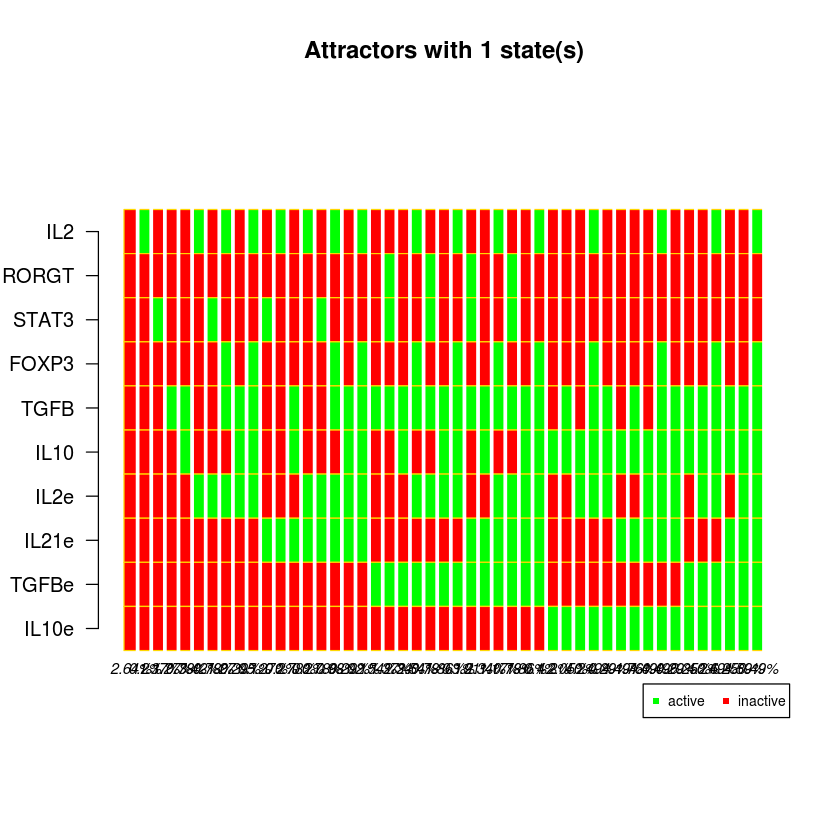

$`1`
      Attr1.1 Attr2.1 Attr3.1 Attr4.1 Attr5.1 Attr6.1 Attr7.1 Attr8.1 Attr9.1
IL2         0       1       0       0       0       1       0       1       0
RORGT       0       0       0       0       0       0       0       0       0
STAT3       0       0       1       0       0       0       1       0       0
FOXP3       0       0       0       0       0       0       0       1       0
TGFB        0       0       0       1       1       0       0       1       1
IL10        0       0       0       0       1       0       0       0       1
IL2e        0       0       0       0       0       1       1       1       1
IL21e       0       0       0       0       0       0       0       0       0
TGFBe       0       0       0       0       0       0       0       0       0
IL10e       0       0       0       0       0       0       0       0       0
      Attr10.1 Attr11.1 Attr12.1 Attr13.1 Attr14.1 Attr15.1 Attr16.1 Attr17.1
IL2          1        0        1        0        1        0        1        0
RORGT        0        0        0        0        0        0        0        0
STAT3        0        1        0        0        0        1        0        0
FOXP3        1        0        0        0        0        0        1        0
TGFB         1        0        0        1        0        0        1        1
IL10         1        0        0        1        0        0        0        1
IL2e         1        0        0        0        1        1        1        1
IL21e        0        1        1        1        1        1        1        1
TGFBe        0        0        0        0        0        0        0        0
IL10e        0        0        0        0        0        0        0        0
      Attr18.1 Attr19.1 Attr20.1 Attr21.1 Attr22.1 Attr23.1 Attr24.1 Attr25.1
IL2          1        0        0        0        1        0        0        1
RORGT        0        0        1        0        0        1        0        0
STAT3        0        0        1        0        0        1        0        0
FOXP3        1        0        0        0        1        0        0        1
TGFB         1        1        1        1        1        1        1        1
IL10         1        0        0        1        0        0        1        1
IL2e         1        0        0        0        1        1        1        1
IL21e        1        0        0        0        0        0        0        0
TGFBe        0        1        1        1        1        1        1        1
IL10e        0        0        0        0        0        0        0        0
      Attr26.1 Attr27.1 Attr28.1 Attr29.1 Attr30.1 Attr31.1 Attr32.1 Attr33.1
IL2          0        0        1        0        0        1        0        0
RORGT        1        0        0        1        0        0        0        0
STAT3        1        0        0        1        0        0        0        0
FOXP3        0        0        1        0        0        1        0        0
TGFB         1        1        1        1        1        1        0        1
IL10         0        1        0        0        1        1        1        1
IL2e         0        0        1        1        1        1        0        0
IL21e        1        1        1        1        1        1        0        0
TGFBe        1        1        1        1        1        1        0        0
IL10e        0        0        0        0        0        0        1        1
      Attr34.1 Attr35.1 Attr36.1 Attr37.1 Attr38.1 Attr39.1 Attr40.1 Attr41.1
IL2          0        1        0        0        0        0        1        0
RORGT        0        0        0        0        0        0        0        0
STAT3        0        0        0        0        0        0        0        0
FOXP3        0        1        0        0        0        0        1        0
TGFB         0        1        1        0        1        0        1        1
IL10         1        1        1        1        1        1        1        1
IL2e         1   

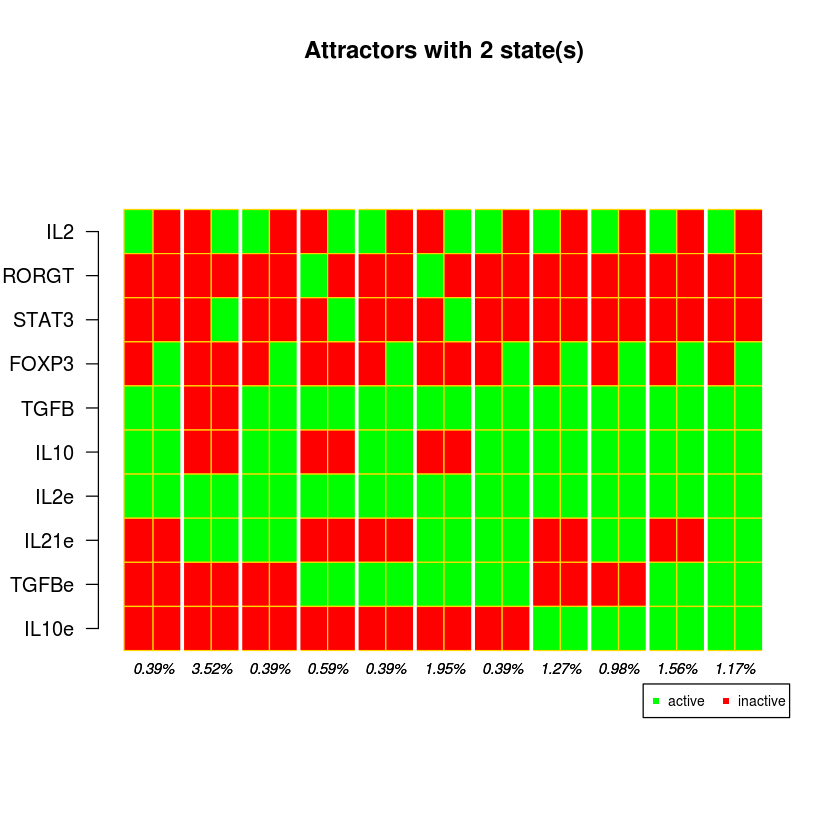

In [13]:
plotAttractors(attr)

We can create a dataframe including only the state and the basin size. However, there are some attractors that have more than one state, which can complicate the process. To solve this we will use the function __attractor2dataframe()__ that transforms the attractors to dataframes. As we can have cyclic states this function will convert the to characters and join them with "\".

In [14]:
attr.df <- attractor2dataframe(attr) 
attr.df

involvedStates basinSize
1               0        27
2               1         2
3               4        14
4              16        13
5              48         8
6              65        35
7              68         8
8              89        13
9             112         3
10            121         1
11            132        54
12            129         2
13            176         8
14            193         2
15            196         8
16            217        10
17            240         3
18            249         1
19            272        26
20            278        14
21            304        24
22            345        26
23            342         8
24            368        19
25            377         1
26            406        40
27            432        24
28            473        12
29            470         8
30            496        19
31            505         1
32            544        43
33            560        21
34            608        43
35            633         5
36            624         3
37            672        46
38            688        18
39            736        46
40            761         5
41            752         3
42            816        64
43            880        43
44            889         5
45            944        64
46           1008        47
47           1017         5
48        113/120         4
49        192/197        36
50        241/248         4
51        338/341         6
52        369/376         4
53        466/469        20
54        497/504         4
55        625/632        13
56        753/760        10
57        881/888        16
58      1009/1016        12

It would also be useful to have the attractors in 0s and 1s format and know the gene names. Lets make a function for this

In [15]:
int2binState <- function(x, genes){ 
    state <- as.integer( intToBits(x)[1:length(genes)] )  
    names(state) <- genes
    state
    }

Using this function we can analyze the active nodes in a state. For example, the attractor 58:

In [16]:
bin.states <- lapply (attr$attractors[[58]]$involvedStates, 
                      int2binState, net$genes)
bin.states

[[1]]
  IL2 RORGT STAT3 FOXP3  TGFB  IL10  IL2e IL21e TGFBe IL10e 
    1     0     0     0     1     1     1     1     1     1 

[[2]]
  IL2 RORGT STAT3 FOXP3  TGFB  IL10  IL2e IL21e TGFBe IL10e 
    0     0     0     1     1     1     1     1     1     1

## Labels

Attractors correspond to cell types. It is very important to verify that all the expected cell types appear in our attractors, if they are not present we might be missing interactions. It is also important to see if there are attractors that do not correspond to known cell types, as they may be predictions or show errors in the construction of the network.

However, when there are a lot of inputs, it is possible that many attractors correspond to a single cell type that can be found in different environments (we will discuss this further). To solve this problem we will label our attractors according to a set of rules.

In the case of the Th17/iTreg network this rules are:

>labels,  rules

>Th0,   ! (RORGT | FOXP3 | TGFB | IL10)

>Th17,  RORgt & STAT3

>iTreg, FOXP3 & TGFB

>IL10+, IL10 & ! (RORGT | FOXP3 | TGFB)

>TGFB+, TGFB & ! (RORGT | FOXP3 | TGFB)

>IL10+TGFB+, (TGFB & IL10) & ! (RORGT | FOXP3)

This rules for labelling can be found in the `BoolNetPerturb` data:

In [17]:
data(labelsRulesTh17iTreg)
labels.rules <- labelsRulesTh17iTreg
labels.rules

labels                          rules
1    Th0 !(RORGT | FOXP3 | TGFB | IL10)
2   Th17                  RORGT & STAT3
3   Treg                   FOXP3 & TGFB
4  IL10+                           IL10
5  TGFB+       TGFB & ! (RORGT | FOXP3)
6 RORGT+                RORGT & ! STAT3

For each rule we can write a function that evaluates  the nodes. For example, for the rule __Th0__ we could write the following rule:

In [18]:
ruleTh0 <- function(
    IL2, RORGT, STAT3, FOXP3, TGFB, IL10, IL2e, IL21e, TGFBe, IL10e
    ) { 
    if (!(RORGT | FOXP3 | TGFB | IL10)) 'Th0' 
}

We can use this function with a binary state. For examplem the state 0 (0,0,0,0,0,0,0,0,0,0) has the label "Th0", but the state 121 (1,0,0,1,1,1,1,,0,0,0) does not.

In [19]:
label <- ruleTh0(0,0,0,0,0,0,0,0,0,0)
label
state <- ruleTh0(1,0,0,1,1,1,1,0,0,0)
state

[1] "Th0"

NULL

We can also give the function a list of named arguments using __do.call()__, this way the function can receive the state obtained from __int2binState()__.

In [20]:
state <- attr$attractors[[1]]$involvedStates
state <- int2binState(state, net$genes)
#state
label <- do.call(ruleTh0, as.list(state))
label

[1] "Th0"

While we could create specific functions for each labeling rule, it is better to make a general function that can interpret our rules. 
The function __labelState()__ takes a binary state with gene names, a set of labels and the rules as strings and returns a label.

In [21]:
state <- int2binState(121, net$genes)
#state
label <- labelState(state, net$genes, labels.rules$labels, labels.rules$rules)
label

[1] "TregIL10+"

Using this method it is possible to label all the states involved in an attractor. The function __labelAttractors()__ takes an attractors object created by BoolNet and returns a list of the labels for each attractor in order. If an attractor has multiple states it will return a label for each state.

Lets obtain the labels of all the attractors using the function __labelAttractors()__.

In [22]:
labels <- labelAttractors(attr, net$genes, labels.rules$labels, labels.rules$rules)
labels

[[1]]
[1] "Th0"

[[2]]
[1] "Th0"

[[3]]
[1] "Th0"

[[4]]
[1] "TGFB+"

[[5]]
[1] "IL10+TGFB+"

[[6]]
[1] "Th0"

[[7]]
[1] "Th0"

[[8]]
[1] "Treg"

[[9]]
[1] "IL10+TGFB+"

[[10]]
[1] "TregIL10+"

[[11]]
[1] "Th0"

[[12]]
[1] "Th0"

[[13]]
[1] "IL10+TGFB+"

[[14]]
[1] "Th0"

[[15]]
[1] "Th0"

[[16]]
[1] "Treg"

[[17]]
[1] "IL10+TGFB+"

[[18]]
[1] "TregIL10+"

[[19]]
[1] "TGFB+"

[[20]]
[1] "Th17"

[[21]]
[1] "IL10+TGFB+"

[[22]]
[1] "Treg"

[[23]]
[1] "Th17"

[[24]]
[1] "IL10+TGFB+"

[[25]]
[1] "TregIL10+"

[[26]]
[1] "Th17"

[[27]]
[1] "IL10+TGFB+"

[[28]]
[1] "Treg"

[[29]]
[1] "Th17"

[[30]]
[1] "IL10+TGFB+"

[[31]]
[1] "TregIL10+"

[[32]]
[1] "IL10+"

[[33]]
[1] "IL10+TGFB+"

[[34]]
[1] "IL10+"

[[35]]
[1] "TregIL10+"

[[36]]
[1] "IL10+TGFB+"

[[37]]
[1] "IL10+"

[[38]]
[1] "IL10+TGFB+"

[[39]]
[1] "IL10+"

[[40]]
[1] "TregIL10+"

[[41]]
[1] "IL10+TGFB+"

[[42]]
[1] "IL10+TGFB+"

[[43]]
[1] "IL10+TGFB+"

[[44]]
[1] "TregIL10+"

[[45]]
[1] "IL10+TGFB+"

[[46]]
[1] "IL10+TGFB+"

[[47]]
[1] "TregIL10+"

[[48]]
[1] "IL10+TGFB+" "TregIL10+" 

[[49]]
[1] "Th0" "Th0"

[[50]]
[1] "IL10+TGFB+" "TregIL10+" 

[[51]]
[1] "RORGT+" "TGFB+" 

[[52]]
[1] "IL10+TGFB+" "TregIL10+" 

[[53]]
[1] "RORGT+" "TGFB+" 

[[54]]
[1] "IL10+TGFB+" "TregIL10+" 

[[55]]
[1] "IL10+TGFB+" "TregIL10+" 

[[56]]
[1] "IL10+TGFB+" "TregIL10+" 

[[57]]
[1] "IL10+TGFB+" "TregIL10+" 

[[58]]
[1] "IL10+TGFB+" "TregIL10+"

We will add the labels to the dataframe we created with __attractor2dataframe()__. To do this we will need to join the labels of the attractors that have more than one state with "/".

In [23]:
attr.df$label <- sapply(labels, function(label) {
    paste(as.character(label), collapse='/')
})
attr.df


involvedStates basinSize                label
1               0        27                  Th0
2               1         2                  Th0
3               4        14                  Th0
4              16        13                TGFB+
5              48         8           IL10+TGFB+
6              65        35                  Th0
7              68         8                  Th0
8              89        13                 Treg
9             112         3           IL10+TGFB+
10            121         1            TregIL10+
11            132        54                  Th0
12            129         2                  Th0
13            176         8           IL10+TGFB+
14            193         2                  Th0
15            196         8                  Th0
16            217        10                 Treg
17            240         3           IL10+TGFB+
18            249         1            TregIL10+
19            272        26                TGFB+
20            278        14                 Th17
21            304        24           IL10+TGFB+
22            345        26                 Treg
23            342         8                 Th17
24            368        19           IL10+TGFB+
25            377         1            TregIL10+
26            406        40                 Th17
27            432        24           IL10+TGFB+
28            473        12                 Treg
29            470         8                 Th17
30            496        19           IL10+TGFB+
31            505         1            TregIL10+
32            544        43                IL10+
33            560        21           IL10+TGFB+
34            608        43                IL10+
35            633         5            TregIL10+
36            624         3           IL10+TGFB+
37            672        46                IL10+
38            688        18           IL10+TGFB+
39            736        46                IL10+
40            761         5            TregIL10+
41            752         3           IL10+TGFB+
42            816        64           IL10+TGFB+
43            880        43           IL10+TGFB+
44            889         5            TregIL10+
45            944        64           IL10+TGFB+
46           1008        47           IL10+TGFB+
47           1017         5            TregIL10+
48        113/120         4 IL10+TGFB+/TregIL10+
49        192/197        36              Th0/Th0
50        241/248         4 IL10+TGFB+/TregIL10+
51        338/341         6         RORGT+/TGFB+
52        369/376         4 IL10+TGFB+/TregIL10+
53        466/469        20         RORGT+/TGFB+
54        497/504         4 IL10+TGFB+/TregIL10+
55        625/632        13 IL10+TGFB+/TregIL10+
56        753/760        10 IL10+TGFB+/TregIL10+
57        881/888        16 IL10+TGFB+/TregIL10+
58      1009/1016        12 IL10+TGFB+/TregIL10+

As we can see some labels have more than one attractor. This is because some cell types can be found in different environments. We can see all the unique labels to determine if all the labels correspond to the expected cell types.

In [ ]:
unique(attr.df$label)

While we have all the expected cell types we have some cycles where one of the states could not be labeled. If we check the dataframe, the states 338 and 466 have no label, we can study them to see what happened.

In [ ]:
state.odd.a1 <- int2binState(338, net$genes)
state.odd.a2 <- int2binState(341, net$genes)
state.odd.a1
state.odd.a2
state.odd.b1 <- int2binState(466, net$genes)
state.odd.b2 <- int2binState(469, net$genes)
state.odd.b1
state.odd.b2

As we can see this states correspond to oscillations where ROR$\gamma$t can not stabilish a stable expression. If we use an asynchronous update this states will dissapear. 

We can create a new rule to include this states.
> RORGT+, RORGT & ! STAT3

In [25]:
labels.rules <- rbind(labels.rules, c('RORGT+', 'RORGT & ! STAT3'))
labels.rules

labels                          rules
1    Th0 !(RORGT | FOXP3 | TGFB | IL10)
2   Th17                  RORGT & STAT3
3   Treg                   FOXP3 & TGFB
4  IL10+                           IL10
5  TGFB+       TGFB & ! (RORGT | FOXP3)
6 RORGT+                RORGT & ! STAT3
7 RORGT+                RORGT & ! STAT3
8 RORGT+                RORGT & ! STAT3

We will need to do the labeling and the dataframe once more.

In [26]:
labels <- labelAttractors(attr, net$genes, labels.rules$labels, labels.rules$rules)
labels <- sapply(labels, function(l) paste(as.character(l), collapse='/'))
attr.df$label <- labels
attr.df

#intersect(WT.attr.df$involvedStates, pertubed.attr.df$involvedStates)
setdiff(WT.attr.df$involvedStates, pertubed.attr.df$involvedStates)

involvedStates basinSize                    label
1               0        27                      Th0
2               1         2                      Th0
3               4        14                      Th0
4              16        13                    TGFB+
5              48         8               IL10+TGFB+
6              65        35                      Th0
7              68         8                      Th0
8              89        13                     Treg
9             112         3               IL10+TGFB+
10            121         1                TregIL10+
11            132        54                      Th0
12            129         2                      Th0
13            176         8               IL10+TGFB+
14            193         2                      Th0
15            196         8                      Th0
16            217        10                     Treg
17            240         3               IL10+TGFB+
18            249         1                TregIL10+
19            272        26                    TGFB+
20            278        14                     Th17
21            304        24               IL10+TGFB+
22            345        26                     Treg
23            342         8                     Th17
24            368        19               IL10+TGFB+
25            377         1                TregIL10+
26            406        40                     Th17
27            432        24               IL10+TGFB+
28            473        12                     Treg
29            470         8                     Th17
30            496        19               IL10+TGFB+
31            505         1                TregIL10+
32            544        43                    IL10+
33            560        21               IL10+TGFB+
34            608        43                    IL10+
35            633         5                TregIL10+
36            624         3               IL10+TGFB+
37            672        46                    IL10+
38            688        18               IL10+TGFB+
39            736        46                    IL10+
40            761         5                TregIL10+
41            752         3               IL10+TGFB+
42            816        64               IL10+TGFB+
43            880        43               IL10+TGFB+
44            889         5                TregIL10+
45            944        64               IL10+TGFB+
46           1008        47               IL10+TGFB+
47           1017         5                TregIL10+
48        113/120         4     IL10+TGFB+/TregIL10+
49        192/197        36                  Th0/Th0
50        241/248         4     IL10+TGFB+/TregIL10+
51        338/341         6 RORGT+RORGT+RORGT+/TGFB+
52        369/376         4     IL10+TGFB+/TregIL10+
53        466/469        20 RORGT+RORGT+RORGT+/TGFB+
54        497/504         4     IL10+TGFB+/TregIL10+
55        625/632        13     IL10+TGFB+/TregIL10+
56        753/760        10     IL10+TGFB+/TregIL10+
57        881/888        16     IL10+TGFB+/TregIL10+
58      1009/1016        12     IL10+TGFB+/TregIL10+

Now that all the states are labeled we can also determine which attractor states correspond to each label and the joint size of the basin of attraction of each label.

In [27]:
attractors.by.label <- data.frame(
    states = tapply(attr.df$involvedStates, attr.df$label, paste),
    basin = tapply(attr.df$basin, attr.df$label, sum)
)
attractors.by.label

states
IL10+                                                                                544, 608, 672, 736
IL10+TGFB+               48, 112, 176, 240, 304, 368, 432, 496, 560, 624, 688, 752, 816, 880, 944, 1008
IL10+TGFB+/TregIL10+           113/120, 241/248, 369/376, 497/504, 625/632, 753/760, 881/888, 1009/1016
RORGT+RORGT+RORGT+/TGFB+                                                               338/341, 466/469
TGFB+                                                                                           16, 272
Th0                                                                 0, 1, 4, 65, 68, 132, 129, 193, 196
Th0/Th0                                                                                         192/197
Th17                                                                                 278, 342, 406, 470
Treg                                                                                  89, 217, 345, 473
TregIL10+                                                       121, 249, 377, 505, 633, 761, 889, 1017
                         basin
IL10+                      178
IL10+TGFB+                 371
IL10+TGFB+/TregIL10+        67
RORGT+RORGT+RORGT+/TGFB+    26
TGFB+                       39
Th0                        152
Th0/Th0                     36
Th17                        70
Treg                        61
TregIL10+                   24

This ends the basic BoolNet tutorial.

# Next

* [Introduction](./RPRN-Introduction.ipynb)
* BoolNet
* [Functions](./RPRN-Functions.ipynb)
* [Updating](./RPRN-Updating.ipynb)
* [States and trajectories](./RPRN-States-Trajectories.ipynb)
* [Appendix](./RPRN-Appendix.ipynb)